In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
from transformers import AutoModel, AutoModelForImageClassification, AutoImageProcessor, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, get_cosine_schedule_with_warmup
import torch.nn.functional as F
import torchaudio

from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

import random
import matplotlib.pyplot as plt
from pathlib import Path

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CLASSES = 207

cuda


In [12]:
class BirdTrainDatasetPrecomputed(Dataset):
    def __init__(self, counts_df, labels_df, data_path='data/precomputed_spectrograms/spectrograms', use_cutmix=True, use_masking=True, num_classes = 206, sample_random_ms = False):
        self.path = data_path
        self.use_cutmix = use_cutmix
        self.use_masking = use_masking
        self.num_classes = num_classes
        self.sample_random_ms = sample_random_ms
        self.labels_df_indexed = labels_df.set_index('file_path')
        self.labels_df = labels_df
        self.counts_df = counts_df

    def __len__(self):
        if self.sample_random_ms:
            return len(self.counts_df)
        return len(self.labels_df) 

    def __getitem__(self, idx):
        path, label = self.get_path_and_label(idx)
        spec = torch.load(path)

        if self.use_cutmix and random.random() < 0.5:
            mix_path, mix_label = self.get_path_and_label(-1)
            mix_spec = torch.load(mix_path)

            if self.use_masking:
                spec = self.xy_masking(spec)
                mix_spec = self.xy_masking(mix_spec)

            spec, label = self.horizontal_cutmix(spec, label, mix_spec, mix_label)

        else:
            if self.use_masking:
                spec = self.xy_masking(spec)
            label = F.one_hot(torch.tensor(label), self.num_classes).float()

        return {
            "pixel_values": spec,
            "labels": label,
            "file_name": str(path),
        }

    def get_path_and_label(self, idx = -1):
        if idx == -1:
            idx = random.randint(0, self.__len__() - 1)
        
        if self.sample_random_ms:
            dir_path = Path(self.counts_df.iloc[idx]['file_path'])
            count = self.counts_df.iloc[idx]['count']
            filename = random.randint(0, count - 1)
            path = dir_path / f"{filename}.pt"
            label = self.labels_df_indexed.loc[str(path)]['label']
            return path, label
        else:
            return self.labels_df.iloc[idx]['file_path'], self.labels_df.iloc[idx]['label']

    def xy_masking(self, spec, num_x_masks=2, num_y_masks=1, max_width=10, max_height=10):
        """
        Applies vertical (x) and horizontal (y) rectangular zero-masks to the spectrogram.
        """
        cloned = spec.clone()
        _, height, width = cloned.shape

        # Apply x-masks (vertical)
        for _ in range(num_x_masks):
            w = random.randint(1, max_width)
            x = random.randint(0, max(0, width - w))
            cloned[:, :, x:x+w] = 0.0

        # Apply y-masks (horizontal)
        for _ in range(num_y_masks):
            h = random.randint(1, max_height)
            y = random.randint(0, max(0, height - h))
            cloned[:, y:y+h, :] = 0.0

        return cloned

    def horizontal_cutmix(self, spec1, label1, spec2, label2, alpha=1.0):
        """
        Mix two spectrograms horizontally (along the time axis),
        and create soft labels using torch.nn.functional.one_hot.
        """
        _, h, w = spec1.shape
        cut_point = random.randint(int(0.3 * w), int(0.7 * w))
        lam = cut_point / w

        # Concatenate spectrograms along the time axis (width)
        new_spec = torch.cat((spec1[:, :, :cut_point], spec2[:, :, cut_point:]), dim=2)

        # Convert scalar labels to one-hot vectors
        label1_onehot = F.one_hot(torch.tensor(label1), num_classes=self.num_classes).float()
        label2_onehot = F.one_hot(torch.tensor(label2), num_classes=self.num_classes).float()

        # Mix the labels
        mixed_label = lam * label1_onehot + (1 - lam) * label2_onehot

        return new_spec, mixed_label

  
def get_datasets(counts_df, labels_df, sample_random = False, use_cutmix = False, use_masking = False):
    """
    divides by original files instead of snippet files to avoid data leakage
    """



    train_counts_df, train_val_df = train_test_split(
      counts_df, 
      test_size=0.2, 
      random_state=42, 
      #stratify=counts_df['label']
    )

    # Filter labels_df using file_num
    train_labels_df = labels_df[labels_df['file_num'].isin(train_counts_df['file_num'])].copy()
    val_labels_df   = labels_df[labels_df['file_num'].isin(train_val_df['file_num'])].copy()
    
    # make the datasets
    train_ds = BirdTrainDatasetPrecomputed(train_counts_df, train_labels_df, num_classes=NUM_CLASSES, sample_random_ms=sample_random, use_cutmix=use_cutmix, use_masking=use_masking)
    val_ds = BirdTrainDatasetPrecomputed(train_val_df, val_labels_df, num_classes=NUM_CLASSES, sample_random_ms=sample_random, use_cutmix=False, use_masking=False)
    
    return train_ds, val_ds

#counts_df = pd.read_csv('/home/andy/Desktop/BirdClef/customSED/data/precomputed_spectrograms/counts.csv')
#labels_df = pd.read_csv('/home/andy/Desktop/BirdClef/customSED/data/precomputed_spectrograms/labels.csv')
counts_df = pd.read_csv('/home/andy/Desktop/BirdClef/customSED/data/precomputed_spectrograms/counts_cleaned.csv')
labels_df = pd.read_csv('/home/andy/Desktop/BirdClef/customSED/data/precomputed_spectrograms/labels_cleaned.csv')
ds_train, ds_val = get_datasets(counts_df, labels_df, sample_random=False, use_cutmix=False, use_masking=False)
print("train_loader", len(ds_train))
print("val_loader", len(ds_val))
print("num_classes", counts_df['label'].max()+1)

train_loader 97677
val_loader 23867
num_classes 206


Filepath: data/precomputed_spectrograms/spectrograms/linwoo1/iNat205552/0.pt
Target: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.,

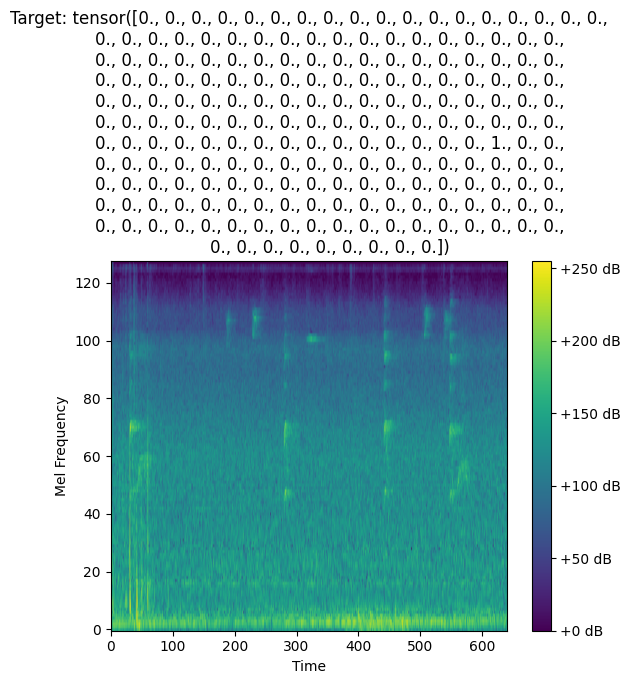

In [13]:
# print a sample spec
res = ds_train[random.randint(0, len(ds_train)-1)]
spec = res['pixel_values']
target = res['labels']

print(f"Filepath: {res['file_name']}")
print(f"Target: {target}")
print(f"Shape of mel spectrogram: {spec.shape}")

# Display the mel spectrogram
plt.imshow(spec[0], aspect='auto', origin='lower')
plt.title(f"Target: {target}")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()

In [84]:
# print train and val loader stats
#train_df = ds_train.counts_df
#val_df = ds_val.counts_df

train_df = ds_train.labels_df
val_df = ds_val.labels_df

def print_label_stats(df, name="Dataset"):
    label_counts = df['label'].value_counts()
    max_count = label_counts.max()
    min_count = label_counts.min()
    mean_count = label_counts.mean()
    std_count = label_counts.std()

    print(f"{name} label statistics:")
    print(f"  Max:  {max_count}")
    print(f"  Min:  {min_count}")
    print(f"  Mean: {mean_count:.2f}")
    print(f"  Std:  {std_count:.2f}")
    print("")

# Print stats for training and validation datasets
print_label_stats(train_df, "Training")
print_label_stats(val_df, "Validation")

Training label statistics:
  Max:  3672
  Min:  3
  Mean: 580.68
  Std:  730.37

Validation label statistics:
  Max:  1183
  Min:  1
  Mean: 153.32
  Std:  189.28



In [5]:
# Define metrics computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    # Defensive check: if labels are soft (i.e., one-hot), convert them
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "f1": f1
    }

In [15]:
# Effnet finetune setup
LR = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
MODEL_NAME = "google/efficientnet-b2"
DROPOUT_RATE = .3

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_CLASSES  # Number of output classes
config.hidden_dropout_prob = DROPOUT_RATE  # Dropout for dense layers
config.attention_probs_dropout_prob = DROPOUT_RATE  # Only applicable if the model has attention layers (EfficientNet doesn't)

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_effnet_cleaned_ds_no_aug_full_epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=LR,
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if available
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=False,
    warmup_steps=500,
    lr_scheduler_type="linear",
)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1408]) in the checkpoint and torch.Size([207, 1408]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([207]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Regnet finetune setup
LR = 1e-5
NUM_EPOCHS = 70
BATCH_SIZE = 64
MODEL_NAME = "facebook/regnet-y-008"
DROPOUT_RATE = .3

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_CLASSES  # Number of output classes
config.hidden_dropout_prob = DROPOUT_RATE  # Dropout for dense layers
config.attention_probs_dropout_prob = DROPOUT_RATE  # Only applicable if the model has attention layers (EfficientNet doesn't)

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./outputs/results_regnet2",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=1e-5,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=LR,
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if available
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=False,
    warmup_steps=500,
    lr_scheduler_type="linear",
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-008 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([207, 768]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([207]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ViT finetune setup
LR = 1e-3
NUM_EPOCHS = 30
BATCH_SIZE = 16
MODEL_NAME = "google/vit-base-patch16-224"  # or any other ViT model you want to use
DROPOUT_RATE = 0.3  # Adjust dropout rate as needed

# Load model with modified dropout
from transformers import ViTConfig

# Load the original config and modify dropout settings
config = ViTConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_CLASSES
config.hidden_dropout_prob = DROPOUT_RATE  # Dropout for feedforward layers
config.attention_probs_dropout_prob = DROPOUT_RATE  # Dropout for attention weights

# Load the model and processor
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True,
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./outputs/results_vit",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=1e-5,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=LR,
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if available
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=False,  # Important for custom datasets
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([206]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([206, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Create and run trainer
class SoftLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # soft labels (probabilities)
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, num_classes)

        # Use log_softmax and soft cross entropy loss
        log_probs = F.log_softmax(logits, dim=-1)
        loss = -(labels * log_probs).sum(dim=-1).mean()

        return (loss, outputs) if return_outputs else loss

trainer = SoftLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
1000,2.536900,2.689476,0.438807,0.391709
2000,1.745400,2.111459,0.553149,0.534449
3000,1.384600,1.853568,0.609796,0.597579
4000,1.139100,1.827781,0.615913,0.609983
5000,1.097700,1.785488,0.624586,0.622362
6000,0.918200,1.742374,0.648469,0.645074
7000,0.720400,1.789046,0.645368,0.643174
8000,0.663700,1.790953,0.649055,0.647121
9000,0.602900,1.838780,0.646793,0.646479
10000,0.458500,1.893744,0.644363,0.641258


TrainOutput(global_step=11000, training_loss=1.2420269196250222, metrics={'train_runtime': 1262.949, 'train_samples_per_second': 7734.042, 'train_steps_per_second': 241.736, 'total_flos': 4.1543588886110003e+18, 'train_loss': 1.2420269196250222, 'epoch': 3.6030134294136915})